In [149]:
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install scikit-learn
# %pip install tensorflow
# %pip install -U imbalanced-learn

In [150]:
import numpy as np
import pandas as pd

In [151]:
COMMODITY = 'magnesium'

DATE_COLUMN = 'Date'
VALUE_COLUMN = 'Value'  
QUANTITY_COLUMN = 'Std. Quantity (KG)'
UNIT_RATE_COLUMN = 'Std. Unit Rate ($/KG)'
BRENT_OIL_COLUMN = 'Brent Oil Value'
WTI_OIL_COLUMN = 'WTI Oil Value'
SHIP_COUNT_COLUMN = 'ship_count'
PORT_COUNT_COLUMN = 'popular_port_count'

VALUE_SPIKES_COLUMN = 'Value Spikes'  
QUANTITY_SPIKES_COLUMN = 'Std. Quantity (KG) Spikes'
UNIT_RATE_SPIKES_COLUMN = 'Std. Unit Rate ($/KG) Spikes'
BRENT_OIL_SPIKES_COLUMN = 'Brent Oil Value Spikes'
WTI_OIL_SPIKES_COLUMN = 'WTI Oil Value Spikes'
SHIP_COUNT_SPIKES_COLUMN = 'Ship Count Spikes'
PORT_COUNT_SPIKES_COLUMN = 'Port Count Spikes'

FEATURE_COLUMNS = [VALUE_COLUMN, QUANTITY_COLUMN, UNIT_RATE_COLUMN,  WTI_OIL_COLUMN, BRENT_OIL_COLUMN, SHIP_COUNT_COLUMN, PORT_COUNT_COLUMN]
# FEATURE_COLUMNS = [VALUE_COLUMN, QUANTITY_COLUMN, UNIT_RATE_COLUMN,  WTI_OIL_SPIKES_COLUMN, BRENT_OIL_SPIKES_COLUMN]
# FEATURE_COLUMNS = [VALUE_COLUMN, QUANTITY_COLUMN, UNIT_RATE_COLUMN,  WTI_OIL_COLUMN, BRENT_OIL_COLUMN, SHIP_COUNT_SPIKES_COLUMN, PORT_COUNT_SPIKES_COLUMN]


ORIGIN_COUNTRY_COLUMN = 'Country of Origin'
DEST_COUNTRY_COLUMN = 'Country of Destination'

PETROL_FILE_PATH = '../volza/petroleum/petrol_crude_oil_spot_price.csv'
VOLZA_FILE_PATH = f'../volza/{COMMODITY}/{COMMODITY}.csv'
PRICE_FILE_PATH = f"../volza/{COMMODITY}/{COMMODITY}_prices.csv"
AIS_POPULAR_FILE_PATH = f'../ais/ais_ml_features.csv' 

NB_OUTPUT_PATH = f"model_performance/{COMMODITY}/{COMMODITY}_model_performance (No Balancing).csv"
RUS_OUTPUT_PATH = f"model_performance/{COMMODITY}/{COMMODITY}_model_performance (Random Under Sampling).csv"
ROS_OUTPUT_PATH = f"model_performance/{COMMODITY}/{COMMODITY}_model_performance (Random Over Sampling).csv"


SPIKES_THRESHOLD = 2
SPIKES_WINDOW_SIZE = 20
BIN_COUNT = 10
FILL_METHOD = 'ffill'

RANDOM_STATE = 42

In [152]:
# Only keep rows where we have usable quantity units (kg, ton) and standardizing it.
def convert_to_kg(df, quantity_col='Std. Quantity', unit_col='Std. Unit'):
    converstion_factors = {
        'TON': 907.185,
        'TNE': 1000,
        'KGS': 1,
        'Kgs': 1,
    }

    df_filtered = df[df[unit_col].isin(converstion_factors.keys())]

    def convert(row):
        unit = row[unit_col]
        quantity = row[quantity_col]
        return quantity * converstion_factors.get(unit,1)
    
    df_filtered = df_filtered[df_filtered[VALUE_COLUMN] != 0]
    df_filtered[QUANTITY_COLUMN] = df_filtered.apply(convert, axis=1)
    df_filtered = df_filtered[df_filtered[QUANTITY_COLUMN] != 0]

    df_filtered[UNIT_RATE_COLUMN] = df_filtered[VALUE_COLUMN] / df_filtered[QUANTITY_COLUMN]

    return df_filtered

## Spike detection

In [153]:
from datetime import datetime

#Formatting the date and price for Volza data
volza_pd = pd.read_csv(VOLZA_FILE_PATH)
volza_pd = volza_pd[(volza_pd["Country of Origin"].notnull()) & (volza_pd["Country of Destination"].notnull())]
volza_pd = volza_pd.rename(columns={'Unnamed: 0': 'ID'})
volza_pd['Date'] = volza_pd['Date'].apply(lambda x: x.split(' ')[0])
volza_pd['Date'] = pd.to_datetime(volza_pd['Date'], errors='raise', format='%Y-%m-%d')
volza_pd = convert_to_kg(volza_pd)
volza_pd.head(3)

,ID,Date,HS Code,Product Description,Consignee,Notify Party Name,Shipper,Std. Quantity,Std. Unit,Standard Unit Rate INR,...,Freight Term,Marks Number,HS Product Description,Gross Weight,Consignee Address,Shipper Address,Notify Party Address,Country Name,Std. Quantity (KG),Std. Unit Rate ($/KG)
0,0,2020-06-09,8104110000,MAGNESIUM METALLIC,CORPORACION ECUATORIANA DE ALUMINIO S A CEDAL,NaN,Ningbo Distant Chemicals Co Ltd,5984.0,KGS,-,...,-,-,Con un contenido de magnesio superior o igual ...,0.0,NaN,"Jingjia Road 188 Long Unit, Jiangdong, Ningbo,...",NaN,Ecuador T3+ Import,5984.0,3.025790
1,1,2020-11-25,8104110000,MAGNESIUM METALLIC INGOTS 99.95%,CORPORACION ECUATORIANA DE ALUMINIO S A CEDAL,NaN,Ningbo Distant Chemicals Co Ltd,3000.0,KGS,-,...,-,-,Con un contenido de magnesio superior o igual ...,0.0,NaN,"Jingjia Road 188 Long Unit, Jiangdong, Ningbo,...",NaN,Ecuador T3+ Import,3000.0,3.057833
3,3,2020-07-30,81041100,MAGNESIUM INGOT,PT LAUTAN LUAS TBK,NaN,POINTER INVESTEMT HK LTD,25.0,TNE,-,...,-,-,NaN,0.0,"Graha Indramas, Gedung, Jl. Ks. Tubun No.77, R...",RM 3408 CHINA MERCHANTS TOWER|SHUN TAK CENTRE ...,NaN,Indonesia T3 Import,25000.0,1.940000


In [154]:
#Preprocessing the AIS data
ais_popular_pd = pd.read_csv(AIS_POPULAR_FILE_PATH)
# volza_pd['Date'] = volza_pd['Date'].apply(lambda x: x.split(' ')[0])
ais_popular_pd['Date'] = pd.to_datetime(ais_popular_pd['Date'])
ais_popular_pd.head(3)


,Date,ship_count,popular_port,popular_port_count
0,2020-11-10,8,LTKLJ,18
1,2020-11-12,20,IDSKP,8
2,2020-11-29,9,CNSHA,2


In [155]:
#Preprocessing the price data
prices_pd = pd.read_csv(PRICE_FILE_PATH)
prices_pd['Date'] = prices_pd['Date'].apply(lambda x: datetime.strptime(x, "%b %d, %Y").strftime("%Y-%m-%d"))
prices_pd['Date'] = pd.to_datetime(prices_pd['Date'], errors='raise', format='%Y-%m-%d')
prices_pd['Price'] = prices_pd['Price'].str.replace(',', '').astype(float)
prices_pd = prices_pd[['Date','Price']]
prices_pd.head(3)

,Date,Price
0,2022-12-30,21650.0
1,2022-12-29,21650.0
2,2022-12-28,21650.0


In [156]:
#Aggregate volza data by day
date_wise_volza = volza_pd.groupby("Date")[[VALUE_COLUMN,QUANTITY_COLUMN,'Gross Weight']].sum()

In [157]:
# Avg of Commodity Price in Volza
avg_price_volza = volza_pd.groupby('Date')[UNIT_RATE_COLUMN].mean()
date_wise_volza = date_wise_volza.join(avg_price_volza, how='left')
date_wise_volza

,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG)
Date,,,,
2020-01-01,3.716627e+07,1.451213e+07,275000.0,8.582012
2020-01-02,1.125000e+05,5.000000e+04,50080.0,2.250000
2020-01-03,8.744076e+05,1.001723e+05,25040.0,768.449153
2020-01-04,2.950597e+05,1.350000e+05,0.0,2.188610
2020-01-05,4.420000e+04,2.000000e+04,0.0,2.210000
...,...,...,...,...
2022-12-27,9.624998e+04,2.500000e+04,25040.0,3.849999
2022-12-28,1.122651e+06,2.869969e+05,80306.0,5.656118
2022-12-29,1.303649e+06,3.568780e+05,0.0,3.490332


In [158]:
# Petroleum data prep
petrol_df = pd.read_csv(PETROL_FILE_PATH, delimiter=';', on_bad_lines='warn')
petrol_df['Date'] = pd.to_datetime(petrol_df['Date'])

# Split based on types of oil
brent_df = petrol_df[petrol_df['product-name']=='UK Brent Crude Oil']
wti_df = petrol_df[petrol_df['product-name']=='WTI Crude Oil']

brent_df.rename(columns={'Value':'Brent Oil Value'}, inplace=True)
wti_df.rename(columns={'Value':'WTI Oil Value'}, inplace=True)


C:\Users\manim\AppData\Local\Temp\ipykernel_5096\273638861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brent_df.rename(columns={'Value':'Brent Oil Value'}, inplace=True)
C:\Users\manim\AppData\Local\Temp\ipykernel_5096\273638861.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wti_df.rename(columns={'Value':'WTI Oil Value'}, inplace=True)


In [159]:
# Combining dataframes
prices_pd = prices_pd.set_index('Date')
ais_popular_pd = ais_popular_pd.set_index('Date')
date_wise_volza = date_wise_volza.join(ais_popular_pd, how="left").fillna(method=FILL_METHOD)
aggregated_df = date_wise_volza.join(prices_pd, how="left").fillna(method=FILL_METHOD)
# date_wise_volza = date_wise_volza.join(ais_popular_pd, how="left").fillna(method='ffill')
aggregated_df = aggregated_df.merge(brent_df[[DATE_COLUMN, BRENT_OIL_COLUMN]], on='Date', how='left').fillna(method=FILL_METHOD)
aggregated_df = aggregated_df.merge(wti_df[[DATE_COLUMN, WTI_OIL_COLUMN]], on='Date', how='left').fillna(method=FILL_METHOD)
aggregated_df

C:\Users\manim\AppData\Local\Temp\ipykernel_5096\261862122.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  date_wise_volza = date_wise_volza.join(ais_popular_pd, how="left").fillna(method=FILL_METHOD)
C:\Users\manim\AppData\Local\Temp\ipykernel_5096\261862122.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggregated_df = date_wise_volza.join(prices_pd, how="left").fillna(method=FILL_METHOD)
C:\Users\manim\AppData\Local\Temp\ipykernel_5096\261862122.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aggregated_df = aggregated_df.merge(brent_df[[DATE_COLUMN, BRENT_OIL_COLUMN]], on='Date', how='left').fillna(method=FILL_METHOD)
C:\Users\manim\AppData\Local\Temp\ipykernel_5096\261862122.py:8: FutureWarning: D

,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),ship_count,popular_port,popular_port_count,Price,Brent Oil Value,WTI Oil Value
0,2020-01-01,3.716627e+07,1.451213e+07,275000.0,8.582012,NaN,NaN,NaN,NaN,67.77,61.14
1,2020-01-02,1.125000e+05,5.000000e+04,50080.0,2.250000,NaN,NaN,NaN,14150.0,67.05,61.17
2,2020-01-03,8.744076e+05,1.001723e+05,25040.0,768.449153,NaN,NaN,NaN,14100.0,69.08,63.00
3,2020-01-04,2.950597e+05,1.350000e+05,0.0,2.188610,NaN,NaN,NaN,14100.0,69.08,63.00
4,2020-01-05,4.420000e+04,2.000000e+04,0.0,2.210000,NaN,NaN,NaN,14100.0,69.08,63.00
...,...,...,...,...,...,...,...,...,...,...,...
964,2022-12-27,9.624998e+04,2.500000e+04,25040.0,3.849999,27245.0,SGSIN,9195.0,21700.0,82.45,79.45
965,2022-12-28,1.122651e+06,2.869969e+05,80306.0,5.656118,26021.0,SGSIN,9233.0,21650.0,81.70,78.89
966,2022-12-29,1.303649e+06,3.568780e+05,0.0,3.490332,24039.0,SGSIN,8861.0,21650.0,80.96,78.43
967,2022-12-30,9.095473e+05,2.128420e+05,44080.0,3.949859,19952.0,SGSIN,8118.0,21650.0,82.82,80.16


In [160]:
def detect_spikes(df, column):
    ## Detecting spikes
    moving_avg = df[column].rolling(window=SPIKES_WINDOW_SIZE).mean()
    std_dev = df[column].rolling(window=SPIKES_WINDOW_SIZE).std()

    # Set a threshold to identify spikes
    return (abs(aggregated_df[column] - moving_avg) > SPIKES_THRESHOLD * std_dev).astype(int)

aggregated_df['spikes'] = detect_spikes(aggregated_df, 'Price')
print("SPIKES : NON SPIKES = ")
print(aggregated_df['spikes'].value_counts())
print("PERCENT OF SPIKES", aggregated_df['spikes'].value_counts()[1]/len(aggregated_df))

SPIKES : NON SPIKES = 
spikes
0    816
1    153
Name: count, dtype: int64
PERCENT OF SPIKES 0.15789473684210525


# **Detect spikes**

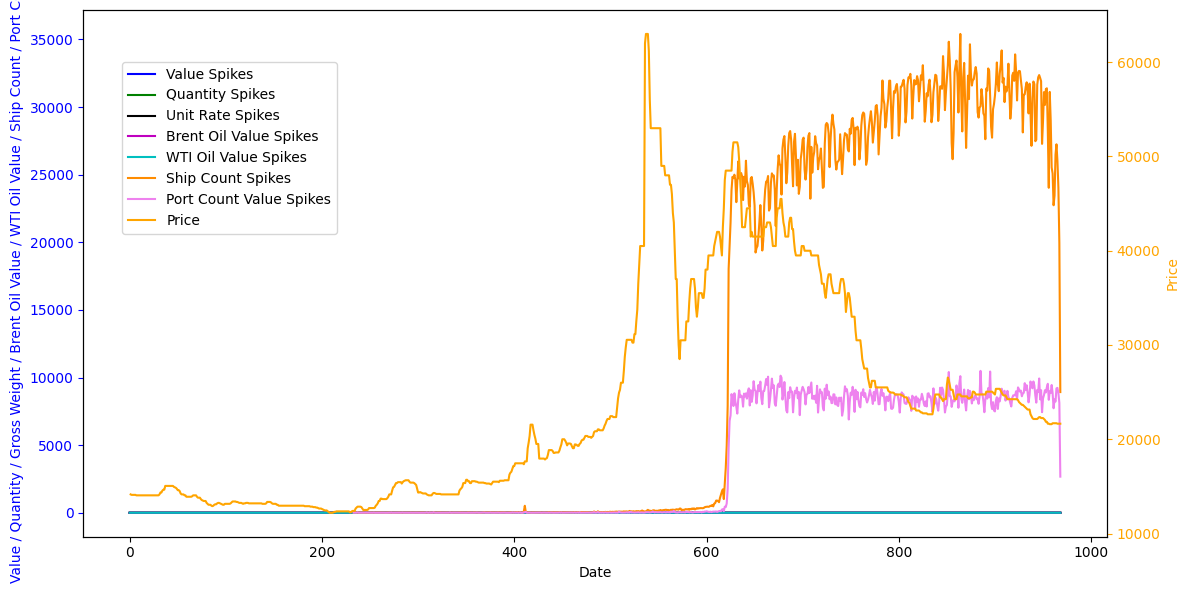

In [161]:
aggregated_df[VALUE_SPIKES_COLUMN] = detect_spikes(aggregated_df, VALUE_COLUMN)
aggregated_df[QUANTITY_SPIKES_COLUMN] = detect_spikes(aggregated_df, QUANTITY_COLUMN)
aggregated_df[UNIT_RATE_SPIKES_COLUMN] = detect_spikes(aggregated_df, UNIT_RATE_COLUMN)
aggregated_df[WTI_OIL_SPIKES_COLUMN] = detect_spikes(aggregated_df, WTI_OIL_COLUMN)
aggregated_df[BRENT_OIL_SPIKES_COLUMN] = detect_spikes(aggregated_df, BRENT_OIL_COLUMN)
aggregated_df[SHIP_COUNT_SPIKES_COLUMN] = detect_spikes(aggregated_df, SHIP_COUNT_COLUMN)
aggregated_df[PORT_COUNT_SPIKES_COLUMN] = detect_spikes(aggregated_df, PORT_COUNT_COLUMN)

#Visualise Dataset

import matplotlib.pyplot as plt
# Plotting the graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting 'Value', 'Quantity', and 'Gross Weight' on the left y-axis
ax1.plot(aggregated_df.index, aggregated_df[VALUE_SPIKES_COLUMN], label='Value Spikes', color='b')
ax1.plot(aggregated_df.index, aggregated_df[QUANTITY_SPIKES_COLUMN], label='Quantity Spikes', color='g')
ax1.plot(aggregated_df.index, aggregated_df[UNIT_RATE_SPIKES_COLUMN], label='Unit Rate Spikes', color='k')
ax1.plot(aggregated_df.index, aggregated_df[BRENT_OIL_SPIKES_COLUMN], label='Brent Oil Value Spikes', color='m')
ax1.plot(aggregated_df.index, aggregated_df[WTI_OIL_SPIKES_COLUMN], label='WTI Oil Value Spikes', color='c')
ax1.plot(aggregated_df.index, aggregated_df[SHIP_COUNT_COLUMN], label='Ship Count Spikes', color='darkorange')
ax1.plot(aggregated_df.index, aggregated_df[PORT_COUNT_COLUMN], label='Port Count Value Spikes', color='violet')

ax1.set_xlabel('Date')
ax1.set_ylabel('Value / Quantity / Gross Weight / Brent Oil Value / WTI Oil Value / Ship Count / Port Count ', color='b')
ax1.tick_params('y', colors='b')

# Creating a second y-axis for 'Price'
ax2 = ax1.twinx()
ax2.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='orange')
ax2.set_ylabel('Price', color='orange')
ax2.tick_params('y', colors='orange')

# Display legend
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the graph
plt.show()

In [162]:
#remove date 2020-01-01
aggregated_df = aggregated_df[aggregated_df.index != '2020-01-01']
aggregated_df

,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),ship_count,popular_port,popular_port_count,Price,Brent Oil Value,WTI Oil Value,spikes,Value Spikes,Std. Quantity (KG) Spikes,Std. Unit Rate ($/KG) Spikes,WTI Oil Value Spikes,Brent Oil Value Spikes,Ship Count Spikes,Port Count Spikes
0,2020-01-01,3.716627e+07,1.451213e+07,275000.0,8.582012,NaN,NaN,NaN,NaN,67.77,61.14,0,0,0,0,0,0,0,0
1,2020-01-02,1.125000e+05,5.000000e+04,50080.0,2.250000,NaN,NaN,NaN,14150.0,67.05,61.17,0,0,0,0,0,0,0,0
2,2020-01-03,8.744076e+05,1.001723e+05,25040.0,768.449153,NaN,NaN,NaN,14100.0,69.08,63.00,0,0,0,0,0,0,0,0
3,2020-01-04,2.950597e+05,1.350000e+05,0.0,2.188610,NaN,NaN,NaN,14100.0,69.08,63.00,0,0,0,0,0,0,0,0
4,2020-01-05,4.420000e+04,2.000000e+04,0.0,2.210000,NaN,NaN,NaN,14100.0,69.08,63.00,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
964,2022-12-27,9.624998e+04,2.500000e+04,25040.0,3.849999,27245.0,SGSIN,9195.0,21700.0,82.45,79.45,0,0,0,0,0,0,0,0
965,2022-12-28,1.122651e+06,2.869969e+05,80306.0,5.656118,26021.0,SGSIN,9233.0,21650.0,81.70,78.89,0,0,0,0,0,0,0,0
966,2022-12-29,1.303649e+06,3.568780e+05,0.0,3.490332,24039.0,SGSIN,8861.0,21650.0,80.96,78.43,0,0,0,0,0,0,0,0
967,2022-12-30,9.095473e+05,2.128420e+05,44080.0,3.949859,19952.0,SGSIN,8118.0,21650.0,82.82,80.16,0,0,0,0,0,0,1,0


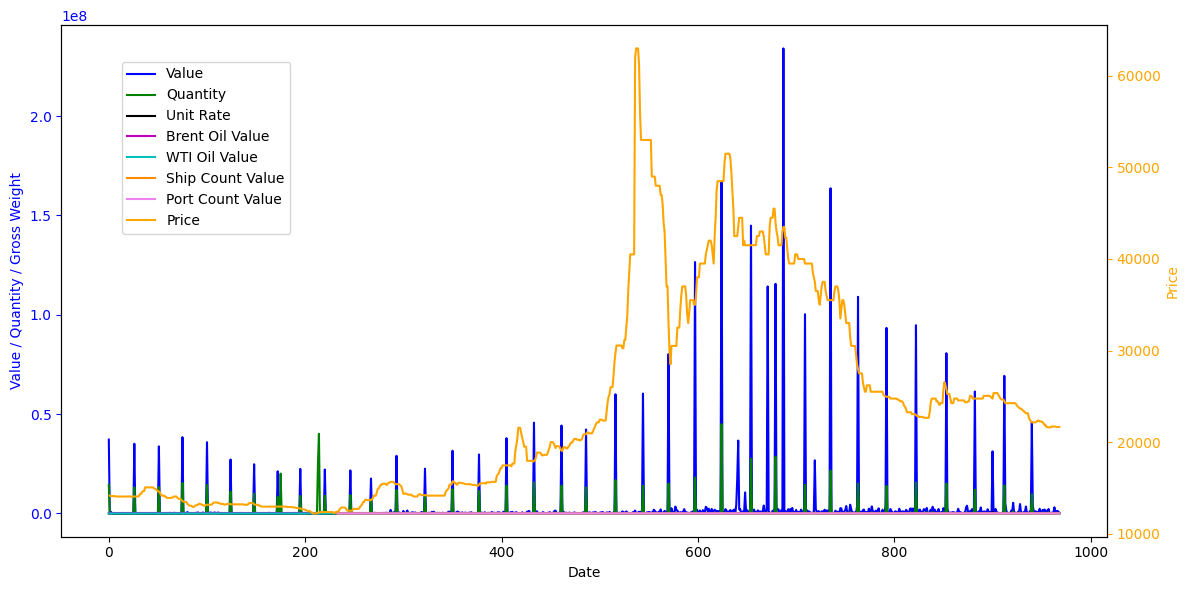

In [163]:
#Visualise Dataset

import matplotlib.pyplot as plt
# Plotting the graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting 'Value', 'Quantity', and 'Gross Weight' on the left y-axis
ax1.plot(aggregated_df.index, aggregated_df[VALUE_COLUMN], label='Value', color='b')
ax1.plot(aggregated_df.index, aggregated_df[QUANTITY_COLUMN], label='Quantity', color='g')
ax1.plot(aggregated_df.index, aggregated_df[UNIT_RATE_COLUMN], label='Unit Rate', color='k')
ax1.plot(aggregated_df.index, aggregated_df[BRENT_OIL_COLUMN], label='Brent Oil Value', color='m')
ax1.plot(aggregated_df.index, aggregated_df[WTI_OIL_COLUMN], label='WTI Oil Value', color='c')
# ax1.plot(aggregated_df.index, aggregated_df['Gross Weight'], label='Gross Weight', color='r')
ax1.plot(aggregated_df.index, aggregated_df[SHIP_COUNT_COLUMN], label='Ship Count Value', color='darkorange')
ax1.plot(aggregated_df.index, aggregated_df[PORT_COUNT_COLUMN], label='Port Count Value', color='violet')

ax1.set_xlabel('Date')
ax1.set_ylabel('Value / Quantity / Gross Weight', color='b')
ax1.tick_params('y', colors='b')

# Creating a second y-axis for 'Price'
ax2 = ax1.twinx()
ax2.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='orange')
ax2.set_ylabel('Price', color='orange')
ax2.tick_params('y', colors='orange')

# Display legend
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the graph
plt.show()

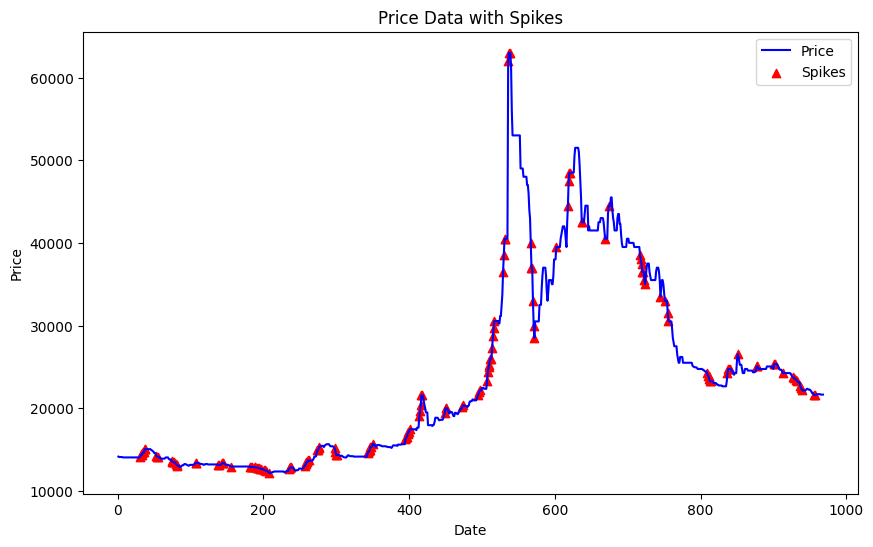

In [164]:
# Plotting the price data
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(aggregated_df.index, aggregated_df['Price'], label='Price', color='blue')

# Highlighting spikes
spike_indices = aggregated_df[aggregated_df['spikes'] == 1].index
spike_prices = aggregated_df.loc[spike_indices, 'Price']
plt.scatter(spike_indices, spike_prices, color='red', marker='^', label='Spikes')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Data with Spikes')
plt.legend()

# Display the plot
plt.show()

## Baseline

In [165]:
# Count % of spikes 
total_spikes = aggregated_df['spikes'].sum()
total_data_points = len(aggregated_df)
percentage_of_spikes = (total_spikes / total_data_points) * 100

print(f"Percentage of Spikes: {percentage_of_spikes:.2f}%")

Percentage of Spikes: 15.79%


In [166]:
from sklearn.metrics import precision_score, recall_score

# Probability of spike
spike_prob = aggregated_df['spikes'].mean()

# Random baseline predictions
random_predictions = np.random.choice([0, 1], size=len(aggregated_df), p=[1-spike_prob, spike_prob])

# Calculate precision and recall for the random baseline
random_precision = precision_score(aggregated_df['spikes'], random_predictions)
random_recall = recall_score(aggregated_df['spikes'], random_predictions)

print(f"Random Guessing Precision: {random_precision}")
print(f"Random Guessing Recall: {random_recall}")


Random Guessing Precision: 0.14925373134328357
Random Guessing Recall: 0.13071895424836602


## Data Prep for Classification

In [167]:
# Discretize
from sklearn.preprocessing import KBinsDiscretizer

def discretize(df, columns, bins):
    est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='kmeans')
    df[columns] = est.fit_transform(df[columns])
    return df

# FEATURES_1 = [VALUE_COLUMN, QUANTITY_COLUMN, UNIT_RATE_COLUMN]
# FEATURES_2 = [WTI_OIL_COLUMN, BRENT_OIL_COLUMN]

test_df = aggregated_df.copy()
test_df[FEATURE_COLUMNS] = test_df[FEATURE_COLUMNS].fillna(0)

# test_df = discretize(test_df, FEATURES_1, 2)
# test_df = discretize(test_df, FEATURES_2, BIN_COUNT)
discretized_df = discretize(test_df, FEATURE_COLUMNS, BIN_COUNT)
# discretized_df = test_df.copy()
test_df.head(2)


c:\Users\manim\LabV2\ONR-Price-Prediction\onr_price_prediction\venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


,Date,Value,Std. Quantity (KG),Gross Weight,Std. Unit Rate ($/KG),ship_count,popular_port,popular_port_count,Price,Brent Oil Value,WTI Oil Value,spikes,Value Spikes,Std. Quantity (KG) Spikes,Std. Unit Rate ($/KG) Spikes,WTI Oil Value Spikes,Brent Oil Value Spikes,Ship Count Spikes,Port Count Spikes
0,2020-01-01,2.0,4.0,275000.0,3.0,0.0,NaN,0.0,NaN,4.0,4.0,0,0,0,0,0,0,0,0
1,2020-01-02,0.0,0.0,50080.0,2.0,0.0,NaN,0.0,14150.0,4.0,4.0,0,0,0,0,0,0,0,0


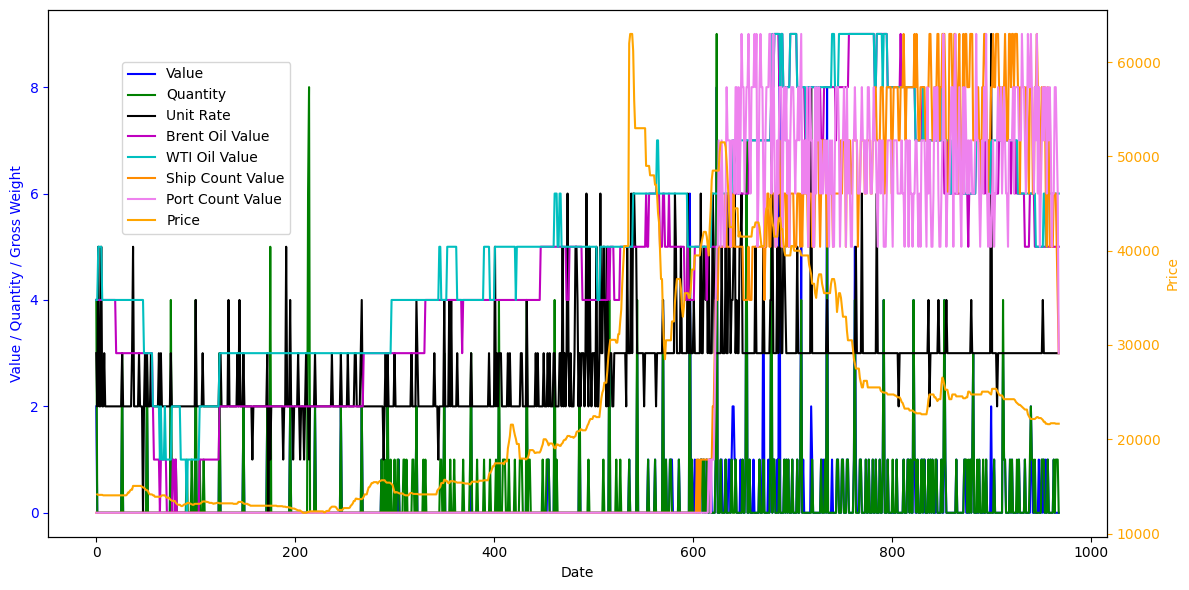

In [168]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting 'Value', 'Quantity', and 'Gross Weight' on the left y-axis
ax1.plot(test_df.index, test_df[VALUE_COLUMN], label='Value', color='b')
ax1.plot(test_df.index, test_df[QUANTITY_COLUMN], label='Quantity', color='g')
ax1.plot(test_df.index, test_df[UNIT_RATE_COLUMN], label='Unit Rate', color='k')
ax1.plot(test_df.index, test_df[BRENT_OIL_COLUMN], label='Brent Oil Value', color='m')
ax1.plot(test_df.index, test_df[WTI_OIL_COLUMN], label='WTI Oil Value', color='c')
ax1.plot(test_df.index, test_df[SHIP_COUNT_COLUMN], label='Ship Count Value', color='darkorange')
ax1.plot(test_df.index, test_df[PORT_COUNT_COLUMN], label='Port Count Value', color='violet')

ax1.set_xlabel('Date')
ax1.set_ylabel('Value / Quantity / Gross Weight', color='b')
ax1.tick_params('y', colors='b')

# Creating a second y-axis for 'Price'
ax2 = ax1.twinx()
ax2.plot(test_df.index, test_df['Price'], label='Price', color='orange')
ax2.set_ylabel('Price', color='orange')
ax2.tick_params('y', colors='orange')

# Display legend
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the graph
plt.show()

C:\Users\manim\AppData\Local\Temp\ipykernel_5096\3838258182.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  unique_values = discretized_df[VALUE_COLUMN].fillna(method=FILL_METHOD).unique()


[2. 0. 1. 3. 4. 6. 8. 7. 5. 9.]


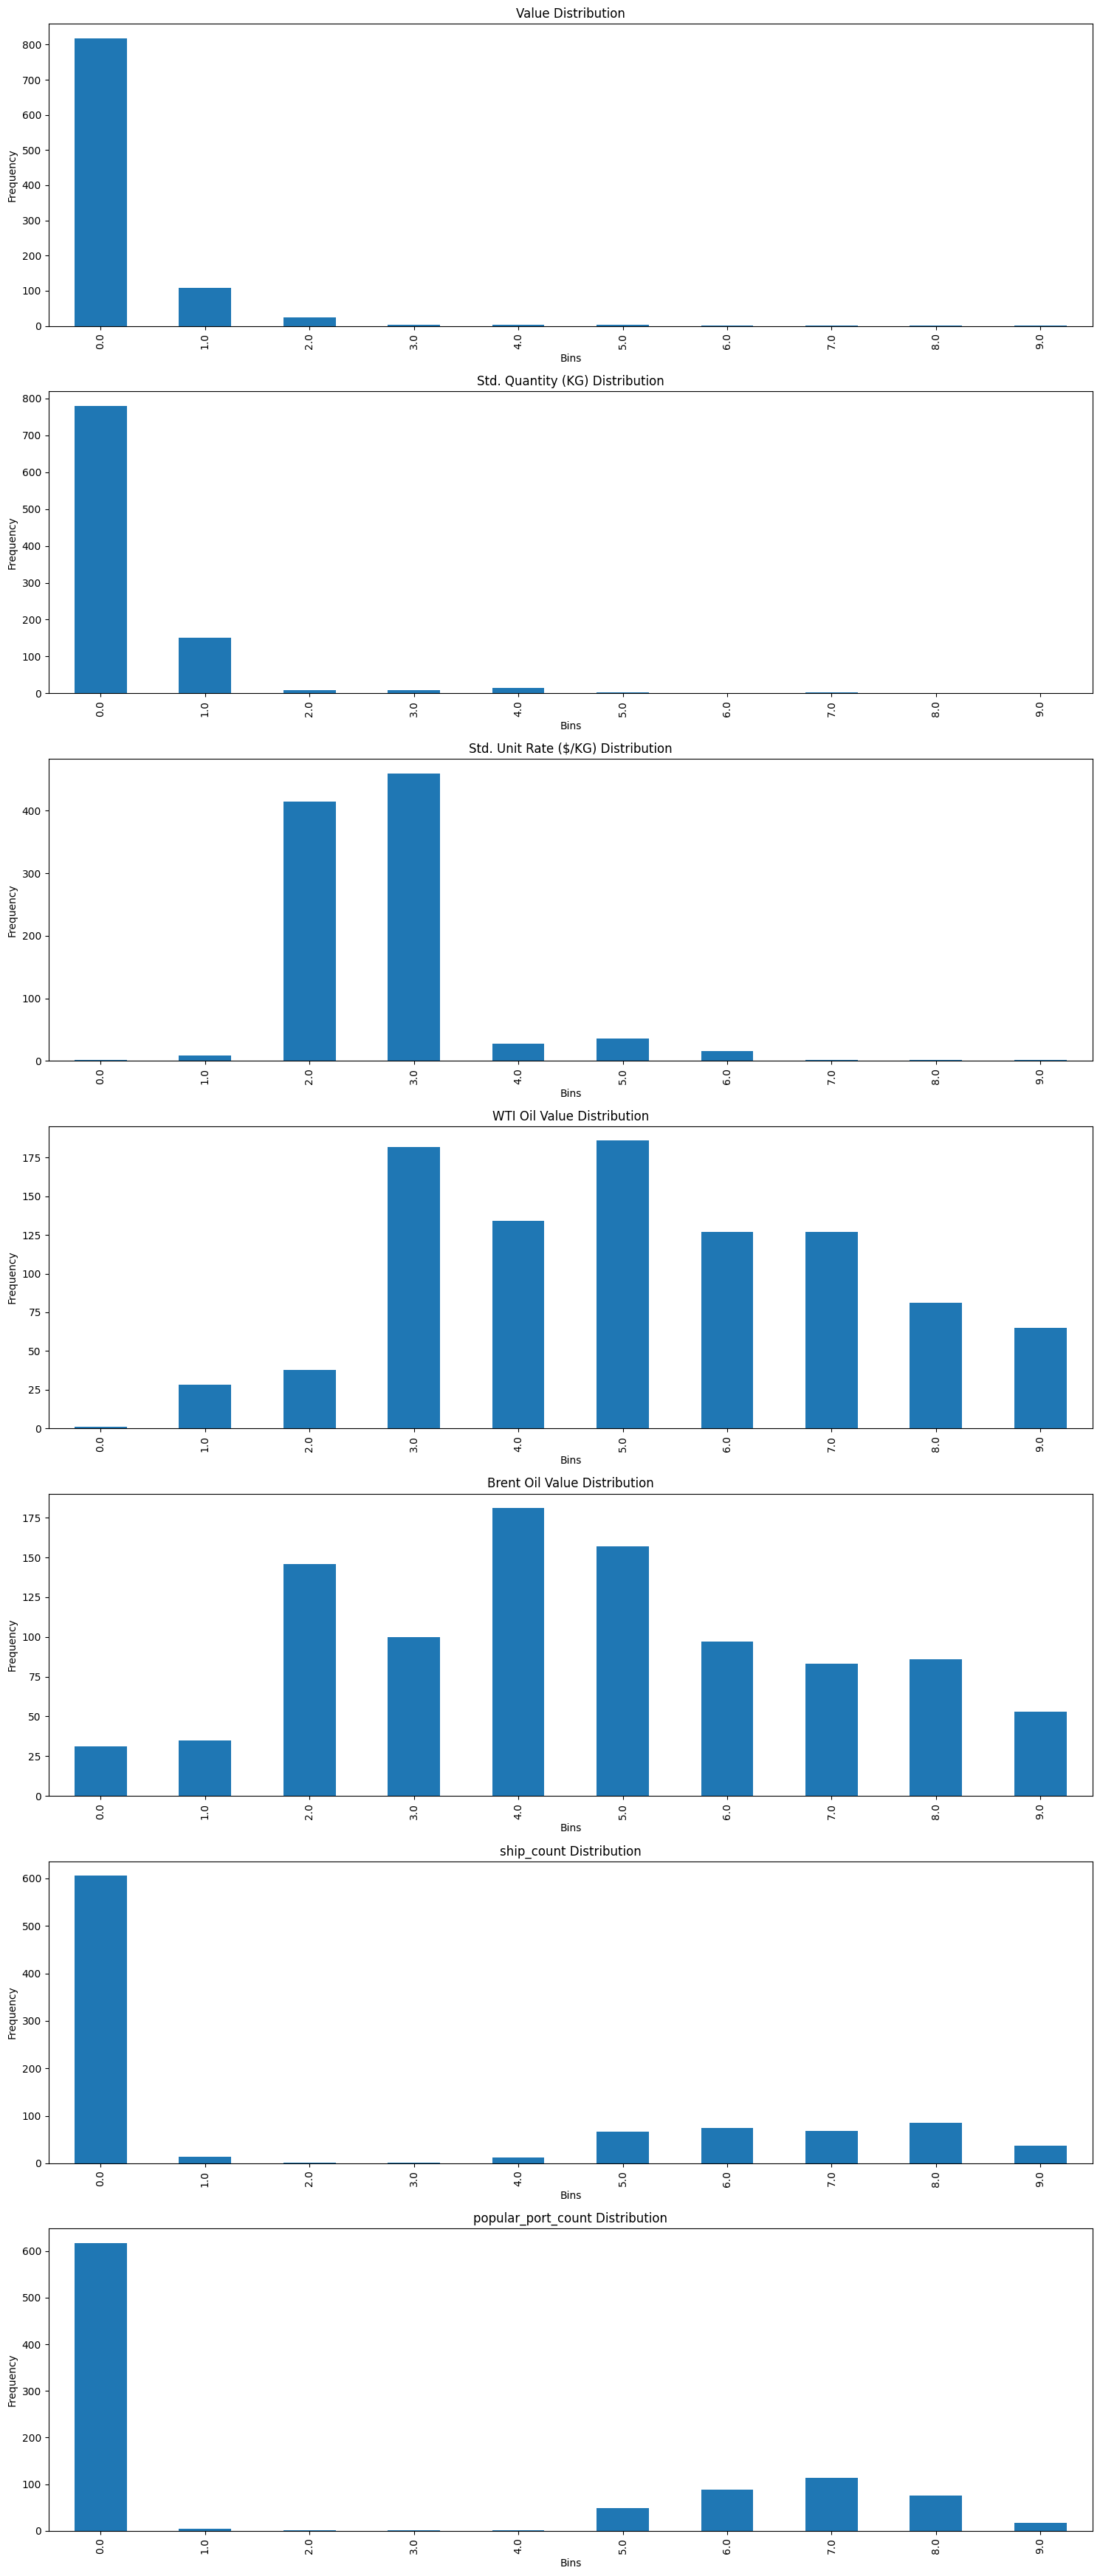

In [169]:
# Convert the discretized data into a DataFrame
discretized_df = pd.DataFrame(discretized_df, columns=FEATURE_COLUMNS)

unique_values = discretized_df[VALUE_COLUMN].fillna(method=FILL_METHOD).unique()
print(unique_values)

bin_counts = {col: discretized_df[col].value_counts() for col in FEATURE_COLUMNS}

# Plotting
plt.figure(figsize=(15, len(FEATURE_COLUMNS) * 5))

for i, column in enumerate(FEATURE_COLUMNS):
    plt.subplot(len(FEATURE_COLUMNS), 1, i + 1)
    bin_counts[column].sort_index().plot(kind='bar', ax=plt.gca())

    plt.title(f'{column} Distribution')
    plt.ylabel('Frequency')
    plt.xlabel('Bins')

plt.tight_layout()
plt.show()


In [170]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, SimpleRNN
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from imblearn.under_sampling import RandomUnderSampler


time_series_df = aggregated_df.copy()
# time_series_df.dropna(inplace=True)

# Drop rows with NaN in the 'spikes' column
time_series_df = time_series_df.dropna(subset=['spikes'])
# discretized_df = discretize(time_series_df[FEATURE_COLUMNS], FEATURE_COLUMNS, BIN_COUNT)
time_series_df[FEATURE_COLUMNS] = discretized_df

# Extract features and target variable
X = time_series_df[FEATURE_COLUMNS].values
y = time_series_df['spikes'].values

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create sequences for each sample with a window size of 20
SPIKES_WINDOW_SIZE = 20
X_sequences, y_sequences = [], []

for i in range(len(X_scaled) - SPIKES_WINDOW_SIZE + 1):
    X_sequences.append(X_scaled[i:i + SPIKES_WINDOW_SIZE, :])
    y_sequences.append(y[i + SPIKES_WINDOW_SIZE - 1])

X_sequences, y_sequences = np.array(X_sequences), np.array(y_sequences)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=50)

In [171]:
def make_output_dict(name, params, classification_report):
    return {
        "Name": name,
        "Params": params,
        "Accuracy": classification_report["accuracy"],
        "Precision (0)": classification_report["0"]["precision"],
        "Recall (0)": classification_report["0"]["recall"],
        "F1 (0)": classification_report["0"]["f1-score"],
        "Precision (1)": classification_report["1"]["precision"],
        "Recall (1)": classification_report["1"]["recall"],
        "F1 (1)": classification_report["1"]["f1-score"],
    }

output_dicts = []

In [172]:
# Transformer
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, MultiHeadAttention, Flatten, Input

def positional_encoding(length, d_model):
    def get_angles(pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates

    angle_rads = get_angles(np.arange(length)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
    
    # Apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # Apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
      
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

def transformer_encoder(inputs, num_heads, ff_dim, dropout=0.1):
    # Multi-head self-attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    # Feed-forward layer
    ff_output = Dense(ff_dim, activation="relu")(attention_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    return LayerNormalization(epsilon=1e-6)(attention_output + ff_output)

# Model configuration
length = SPIKES_WINDOW_SIZE  
d_model = len(FEATURE_COLUMNS) 

def build_transformer(num_encoder_layers):
    inputs = Input(shape=(length, d_model))
    x = inputs + positional_encoding(length, d_model)

    for _ in range(num_encoder_layers):
        x = transformer_encoder(x, num_heads=4, ff_dim=128)

    x = Flatten()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Evaluate Transformer model
def evaluate_transformer(num_encoder_layers):
    model = build_transformer(num_encoder_layers)
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)

    y_pred = (model.predict(X_test) > 0.5).astype(int)
    report = classification_report(y_test, y_pred, output_dict=True)
    return make_output_dict(f"Transformer", f"{num_encoder_layers} encoder layers", report)


In [173]:
#LSTM Model
def evaluate_lstm(num_layers: int):
  # Build the LSTM model
  model = Sequential()
  model.add(LSTM(num_layers, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

  # Train the model
  model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)


  y_pred = (model.predict(X_test) > 0.5).astype(int)
  return make_output_dict(f"LSTM", f"{num_layers} layers", classification_report(y_test, y_pred, output_dict=True))


In [174]:
def evaluate_rnn(num_units: int):
    # Build the RNN model
    model = Sequential()
    model.add(SimpleRNN(num_units, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)

    # Predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Generate classification report
    return make_output_dict("RNN", f"{num_units} units", classification_report(y_test, y_pred, output_dict=True))

In [175]:
# Build the CNN model
def evaluate_cnn(num_filters: int, kernel_size: int):

    model = Sequential()
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=False)

    # Predictions
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Generate classification report
    return make_output_dict("CNN", f"{num_filters} filters, kernel size {kernel_size}", classification_report(y_test, y_pred, output_dict=True))


In [176]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Attention, Reshape
from tensorflow.keras.models import Model

# Attention CNN
def create_acnn_model(input_shape, num_classes, filters, kernel_size):
    inputs = tf.keras.Input(shape=input_shape)

    # CNN layers
    conv1 = Conv1D(filters, kernel_size=kernel_size, activation='relu')(inputs)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    # Calculate the new shape for dynamic reshaping
    conv_shape = conv1.shape.as_list()
    new_shape = (-1, conv_shape[1] * conv_shape[2] // 2)

    # Reshape for attention
    reshape = Reshape(new_shape)(pool1)

    # Attention mechanism
    attention = Attention()([reshape, reshape])

    # Flatten for fully connected layers
    flatten = Flatten()(attention)

    # Fully connected layers
    dense1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(num_classes, activation='softmax')(dropout)

    model = Model(inputs=inputs, outputs=outputs)

    return model

def evaluate_attention_cnn(filters, kernel_size):
    model = create_acnn_model(X_train.shape[1:], 2, filters, kernel_size)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=100, batch_size=filters, verbose=False)
    y_pred = model.predict(X_test)
    return make_output_dict("CNN with Attention", f"{filters} filters, kernel size {kernel_size}", classification_report(y_test, y_pred.argmax(axis=1), output_dict=True))

## LSTM (100 layers)

In [177]:
#LSTM Model

output_dicts.append(evaluate_lstm(250))
output_dicts.append(evaluate_lstm(200))
output_dicts.append(evaluate_lstm(100))
output_dicts.append(evaluate_lstm(50))


6/6 [==============================] - 0s 2ms/step


In [178]:
output_dicts.append(evaluate_attention_cnn(32, 7))
output_dicts.append(evaluate_attention_cnn(64, 7))
output_dicts.append(evaluate_attention_cnn(128, 7))
output_dicts.append(evaluate_attention_cnn(256, 7))
output_dicts.append(evaluate_attention_cnn(32, 5))
output_dicts.append(evaluate_attention_cnn(64, 5))
output_dicts.append(evaluate_attention_cnn(128, 5))
output_dicts.append(evaluate_attention_cnn(256, 5))
output_dicts.append(evaluate_attention_cnn(64, 3))
output_dicts.append(evaluate_attention_cnn(128, 3))
output_dicts.append(evaluate_attention_cnn(256, 3))

6/6 [==============================] - 0s 2ms/step


## RNN

In [179]:
output_dicts.append(evaluate_rnn(200))
output_dicts.append(evaluate_rnn(150))
output_dicts.append(evaluate_rnn(100))
output_dicts.append(evaluate_rnn(50))


6/6 [==============================] - 1s 2ms/step


## CNN

In [180]:
output_dicts.append(evaluate_cnn(64, 3))
output_dicts.append(evaluate_cnn(128, 3))
output_dicts.append(evaluate_cnn(256, 3))
output_dicts.append(evaluate_cnn(64, 5))
output_dicts.append(evaluate_cnn(128, 5))
output_dicts.append(evaluate_cnn(256, 5))

6/6 [==============================] - 0s 2ms/step


## Transformer

In [181]:
output_dicts.append(evaluate_transformer(1))
output_dicts.append(evaluate_transformer(2))
output_dicts.append(evaluate_transformer(3))
output_dicts.append(evaluate_transformer(4))

6/6 [==============================] - 1s 6ms/step


In [182]:
output_dicts = pd.DataFrame(output_dicts)
output_dicts.to_csv(NB_OUTPUT_PATH)
output_dicts

,Name,Params,Accuracy,Precision (0),Recall (0),F1 (0),Precision (1),Recall (1),F1 (1)
0,LSTM,250 layers,0.884211,0.925466,0.937107,0.931250,0.655172,0.612903,0.633333
1,LSTM,200 layers,0.868421,0.924051,0.918239,0.921136,0.593750,0.612903,0.603175
2,LSTM,100 layers,0.868421,0.918750,0.924528,0.921630,0.600000,0.580645,0.590164
3,LSTM,50 layers,0.894737,0.926380,0.949686,0.937888,0.703704,0.612903,0.655172
4,CNN with Attention,"32 filters, kernel size 7",0.847368,0.886905,0.937107,0.911315,0.545455,0.387097,0.452830
5,CNN with Attention,"64 filters, kernel size 7",0.863158,0.893491,0.949686,0.920732,0.619048,0.419355,0.500000
6,CNN with Attention,"128 filters, kernel size 7",0.873684,0.899408,0.955975,0.926829,0.666667,0.451613,0.538462
7,CNN with Attention,"256 filters, kernel size 7",0.868421,0.885057,0.968553,0.924925,0.687500,0.354839,0.468085
8,CNN with Attention,"32 filters, kernel size 5",0.847368,0.877907,0.949686,0.912387,0.555556,0.322581,0.408163
9,CNN with Attention,"64 filters, kernel size 5",0.852632,0.883041,0.949686,0.915152,0.578947,0.354839,0.440000


In [183]:
def evaluate_all_models(output_file_name):
  output_dicts = []
  output_dicts.append(evaluate_lstm(250))
  output_dicts.append(evaluate_lstm(200))
  output_dicts.append(evaluate_lstm(100))
  output_dicts.append(evaluate_lstm(50))

  output_dicts.append(evaluate_attention_cnn(32, 5))
  output_dicts.append(evaluate_attention_cnn(64, 5))
  output_dicts.append(evaluate_attention_cnn(128, 5))
  output_dicts.append(evaluate_attention_cnn(256, 5))
  output_dicts.append(evaluate_attention_cnn(64, 3))
  output_dicts.append(evaluate_attention_cnn(128, 3))
  output_dicts.append(evaluate_attention_cnn(256, 3))

  # output_dicts.append(evaluate_random_forest(50))
  # output_dicts.append(evaluate_random_forest(25))
  # output_dicts.append(evaluate_random_forest(20))
  # output_dicts.append(evaluate_random_forest(10))
  # output_dicts.append(evaluate_random_forest(5))

  output_dicts.append(evaluate_rnn(200))
  output_dicts.append(evaluate_rnn(150))
  output_dicts.append(evaluate_rnn(100))
  output_dicts.append(evaluate_rnn(50))

  output_dicts.append(evaluate_cnn(64, 3))
  output_dicts.append(evaluate_cnn(128, 3))
  output_dicts.append(evaluate_cnn(256, 3))
  output_dicts.append(evaluate_cnn(64, 5))
  output_dicts.append(evaluate_cnn(128, 5))
  output_dicts.append(evaluate_cnn(256, 5))

  output_dicts.append(evaluate_transformer(1))
  output_dicts.append(evaluate_transformer(2))
  output_dicts.append(evaluate_transformer(3))
  output_dicts.append(evaluate_transformer(4))



  output_dicts = pd.DataFrame(output_dicts)
  output_dicts.to_csv(output_file_name)
  # output_dicts

# **Ablation**

### **Random Under Sampling**

In [184]:
# from imblearn.under_sampling import RandomUnderSampler
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler


# time_series_df = aggregated_df.copy()

# # Drop rows with NaN in the 'spikes' column
# time_series_df = time_series_df.dropna(subset=['spikes'])
# discretized_df = discretize(time_series_df[FEATURE_COLUMNS], FEATURE_COLUMNS, BIN_COUNT)
# time_series_df[FEATURE_COLUMNS] = discretized_df

# # Extract features and target variable BEFORE creating sequences
# X = time_series_df[FEATURE_COLUMNS].values
# y = time_series_df['spikes'].values

# # Feature scaling using StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Apply RandomOverSampler BEFORE creating sequences
# random_under_sampler = RandomUnderSampler(random_state=RANDOM_STATE)
# X_scaled_resampled, y_resampled = random_under_sampler.fit_resample(X_scaled, y)

# # Recreate sequences with resampled data
# X_sequences_resampled, y_sequences_resampled = [], []
# for i in range(len(X_scaled_resampled) - SPIKES_WINDOW_SIZE + 1):
#     X_sequences_resampled.append(X_scaled_resampled[i:i + SPIKES_WINDOW_SIZE, :])
#     y_sequences_resampled.append(y_resampled[i + SPIKES_WINDOW_SIZE - 1])

# X_sequences_resampled, y_sequences_resampled = np.array(X_sequences_resampled), np.array(y_sequences_resampled)

# # Split the resampled sequences into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_sequences_resampled, y_sequences_resampled, test_size=0.2, random_state=50)

# # Proceed with model training and evaluation
# evaluate_all_models(RUS_OUTPUT_PATH)


### **Random Over Sampling**

In [185]:
# from imblearn.over_sampling import RandomOverSampler

# time_series_df = aggregated_df.copy()

# # Drop rows with NaN in the 'spikes' column
# time_series_df = time_series_df.dropna(subset=['spikes'])
# discretized_df = discretize(time_series_df[FEATURE_COLUMNS], FEATURE_COLUMNS, BIN_COUNT)
# time_series_df[FEATURE_COLUMNS] = discretized_df

# # Extract features and target variable BEFORE creating sequences
# X = time_series_df[FEATURE_COLUMNS].values
# y = time_series_df['spikes'].values

# # Feature scaling using StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Apply RandomUnderSampler BEFORE creating sequences
# random_over_sampler = RandomOverSampler(random_state=RANDOM_STATE)
# X_scaled_resampled, y_resampled = random_over_sampler.fit_resample(X_scaled, y)

# # Recreate sequences with resampled data
# X_sequences_resampled, y_sequences_resampled = [], []
# for i in range(len(X_scaled_resampled) - SPIKES_WINDOW_SIZE + 1):
#     X_sequences_resampled.append(X_scaled_resampled[i:i + SPIKES_WINDOW_SIZE, :])
#     y_sequences_resampled.append(y_resampled[i + SPIKES_WINDOW_SIZE - 1])

# X_sequences_resampled, y_sequences_resampled = np.array(X_sequences_resampled), np.array(y_sequences_resampled)

# # Split the resampled sequences into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_sequences_resampled, y_sequences_resampled, test_size=0.2, random_state=50)

# evaluate_all_models(ROS_OUTPUT_PATH)